In [1]:
#notebook in full screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import os

#if we need to read the image from a ZIP file:
import zipfile
import nrrd

#TensorFlow:
import tensorflow as tf
from tensorflow import keras
##check for GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#tqdm (tune the verbose)
from tqdm.keras import TqdmCallback
#tensorflow addons:
import tensorflow_addons as tfa

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17426131164352101009
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9658306023882361873
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7046801664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2624020027516201582
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12064929301840839993
physical_device_desc: "device: XLA_GPU device"
]


# Loading the data:

In [3]:
#load data:
normalized_test_inputs = np.load('preprocessed_numpy_arrays/normalized_test_inputs.npy')
NUM_TEST_SAMPLES=normalized_test_inputs.shape[0]

# Load the model:

In [4]:
DEPTH_SAMPLES = 2 #i.e. our 3rd dim deepth
JUMP_LENGTH = 1 #i.e. the "space" between slices

In [5]:
def softDiceAndBinCrossEntropy_loss(y_true, y_pred):
    ###################################################y_true = tf.dtypes.cast(y_true, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    softDice = (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)
    #we do 1-softDice since we minimize the loss but softDice need to be maximized
    softDice_loss = 1. - softDice
    
    bce = tf.keras.losses.BinaryCrossentropy()

    return (softDice_loss+bce(y_true, y_pred))/2.



def softIoU(y_true, y_pred):
    ###################################################y_true = tf.dtypes.cast(y_true, tf.float32)
    numerator = tf.reduce_sum(tf.math.multiply(y_true, y_pred))
    denominator = tf.reduce_sum(tf.math.subtract(tf.math.add(y_true, y_pred), tf.math.multiply(y_true, y_pred)))
    return tf.math.divide(numerator, denominator)

In [6]:
#load the trained model:
model = tf.keras.models.load_model('saved_model/models_combined_drop_aug_3D_2_1_UNET_50EPOCH_simple_model', custom_objects={'softIoU':softIoU, 'softDiceAndBinCrossEntropy_loss':softDiceAndBinCrossEntropy_loss})

# Do prediction:

In [7]:
result = np.zeros(normalized_test_inputs.shape)
result.shape

(249, 512, 512, 1)

In [8]:
for sliceIndex in np.arange(0, result.shape[0]-2):#iterate throught all slices (2 times each slices) and add their prediction to the result 3D array
    tmpPrediction = model.predict(tf.convert_to_tensor([normalized_test_inputs[sliceIndex:sliceIndex+2]], dtype=tf.float64)).round()
    result[sliceIndex:sliceIndex+2]=result[sliceIndex:sliceIndex+2]+tmpPrediction[0]
    print(str(sliceIndex+1)+"th slice over "+str(result.shape[0]-2)+" slices")

1th slice over 247 slices
2th slice over 247 slices
3th slice over 247 slices
4th slice over 247 slices
5th slice over 247 slices
6th slice over 247 slices
7th slice over 247 slices
8th slice over 247 slices
9th slice over 247 slices
10th slice over 247 slices
11th slice over 247 slices
12th slice over 247 slices
13th slice over 247 slices
14th slice over 247 slices
15th slice over 247 slices
16th slice over 247 slices
17th slice over 247 slices
18th slice over 247 slices
19th slice over 247 slices
20th slice over 247 slices
21th slice over 247 slices
22th slice over 247 slices
23th slice over 247 slices
24th slice over 247 slices
25th slice over 247 slices
26th slice over 247 slices
27th slice over 247 slices
28th slice over 247 slices
29th slice over 247 slices
30th slice over 247 slices
31th slice over 247 slices
32th slice over 247 slices
33th slice over 247 slices
34th slice over 247 slices
35th slice over 247 slices
36th slice over 247 slices
37th slice over 247 slices
38th slice

In [9]:
result = result.reshape(normalized_test_inputs.shape[:-1]).astype(bool).astype(int)#gives desired final shape & 0,1 values

# Quick visualization:

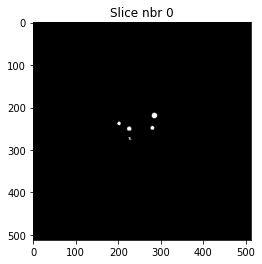

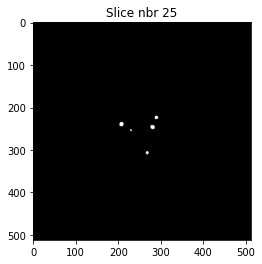

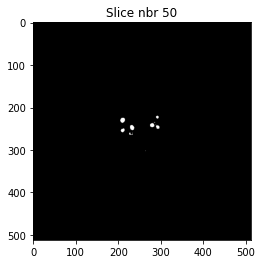

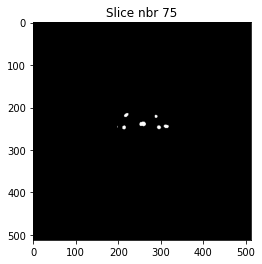

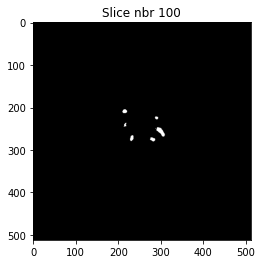

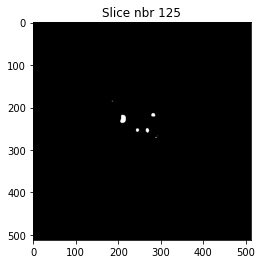

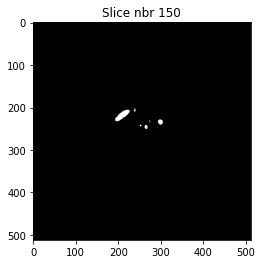

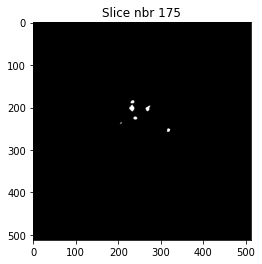

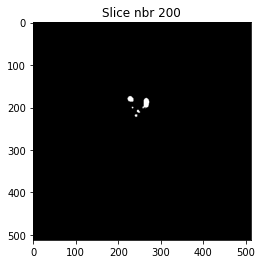

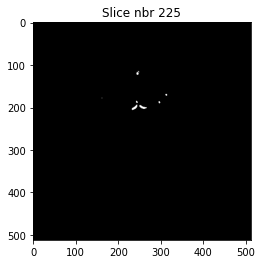

In [10]:
for sliceIndex in np.arange(0, result.shape[0], 25):
    plt.title('Slice nbr '+str(sliceIndex))
    plt.imshow(result[sliceIndex], cmap="gray") 
    plt.show() 

# Save prediction:

In [11]:
nrrd.write('predictions/predictedMask_2_1.nrrd', result, index_order="C")